In [1]:
__author__ = 'Stephanie Juneau, Astro Data Lab Team'
__version__ = '20211122' # yyyymmdd
__datasets__ = ['ls_dr3','sdss_dr13']
__keywords__ = ['extragalactic','galaxies','joint query','spectroscopic redshift']

# DECaLS and SDSS/BOSS Large Scale Structure
by Stéphanie Juneau and the Astro Data Lab Team

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Joint Query of LS and SDSS catalogs](#query)
* [Plot Results](#plots)
* [Exercise](#exercise)

<a class="anchor" id="goals"></a>
# Goals
* Joint query between photometric (LS) and spectroscopic (SDSS) catalogs
* Plot on-sky position of extragalactic objects, color-coded by redshift

# Summary

In this Notebook, we explore large-scale structures of galaxies by combining spectroscopic redshifts from SDSS/BOSS with photometry from the DESI pre-imaging Legacy Survey (LS). The advantage of spectroscopic redshifts is that they are far more accurate than photometric redshifts to probe distances to galaxies (though still need to be corrected for possible distortion effects such as the finger-of-God effect, which we ignore here). The advantage of the LS photometry is that it reaches deeper than SDSS by about 1 magnitude, which yields better image quality to measure magnitudes, colors, and galaxy shapes. While there are several possible extensions to the example work included below, we will show that a simple figure of galaxy spatial locations color-coded by galaxy morphological type reveals the known morphology-density relation.

On a technical point of view, this short notebook illustrates an example joint query between the LS DR3 photometry Tractor table, and the SDSS/BOSS DR13 specObj spectroscopy table. It takes advantage of the fact that there is a version of the LS DR3 tractor table that was pre-matched to SDSS/BOSS DR13 so we can join on a common column called **specobjid**.

The columns from the LS table used (Tractor, pre-matched to specObj DR13) can be seen here: http://datalab.noirlab.edu/query.php?name=ls_dr3.dr3_specobj_dr13

The columns from the SDSS/BOSS DR13 table can be seen here: http://datalab.noirlab.edu/query.php?name=sdss_dr13.specobj


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

Please note that this notebook is written for Python 3.

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table

# Data Lab
from dl import queryClient as qc

print('Done importing')

Done importing


<a class="anchor" id="query"></a>
# Query DECaLS Tractor Photometry Catalog

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as other quantities. 

The Legacy Survey DR3 database is called **ls_dr3** and includes several tables. We will use the **dr3_specobj_dr13** table, which is a version of the LS DR3 tractor table which was pre-matched with specObj table from SDSS/BOSS DR13. The column names and descriptions can be found from the [Data Lab Query Interface](http://datalab.noirlab.edu/query.php) or using the Table Access Protocol (TAP) service with, e.g., TOPCAT. In both cases, we are interested in **ls_dr3.dr3_specobj_dr13**. 

The SDSS DR13 database is called **sdss_dr13** and also includes several tables. We will use the **specObj** table, which has spectroscopic information.

In [3]:
%%time
# number of rows from LS DR3 tractor (NOTE: tractor is the main photometry table):
query="SELECT nrows FROM tbl_stat WHERE schema='ls_dr3' and tbl_name='tractor'"

# Call query manager
response = qc.query(sql=query, fmt='csv')

print(response)
print('Time')

nrows
0

Time
CPU times: user 37.8 ms, sys: 10.8 ms, total: 48.6 ms
Wall time: 428 ms


In [4]:
%%time
# number of rows from SDSS specObj DR13:
query="SELECT nrows FROM tbl_stat WHERE schema='sdss_dr13' and tbl_name='specobj'"

# Call query manager
response = qc.query(sql=query, fmt='csv')

print(response)
print('Time')

nrows
4411200

Time
CPU times: user 38.8 ms, sys: 0 ns, total: 38.8 ms
Wall time: 388 ms


In [5]:
# ls_dr3.dr3_specobj_dr13           #DECaLS matched to SDSS DR13 specobj
# sdss_dr13.specobj                 #SDSS DR13 specobj

# Write query statement (adql)
query = ("""SELECT 
           L.ra,L.dec,L.type,L.g_r,L.r_z,
           S.z,S.plug_ra,S.plug_dec,S.class, 
           S.vdisp,S.vdisp_err 
         FROM ls_dr3.dr3_specobj_dr13 as L JOIN sdss_dr13.specobj as S 
         ON L.specObjId = S.specobjid 
         WHERE L.ra BETWEEN %s and %s and L.dec BETWEEN %s and %s and (L.ra_ivar > 0) 
         limit 100000""") %(126,131,7.,12.)  #small region

# L.ra, L.dec      = RA, Dec from Legacy Survey (LS) table    
# L.type           = object type (PSF, SIMP, EXP, DEV, COMP)
# L.g_r, L.r_z     = pre-computed g-r and r-z colors from photometry
# S.z              = redshift (z) from SDSS specObj table
# S.plug_ra,dec    = RA, Dec of SDSS fiber from specObj table
# S.class          = Source class (Star, Galaxy, QSO) from SDSS
# S.vdisp,vdisp_err= velocity dispersion (and error) from SDSS specObj table
#
# WHERE: requirement that RA & Dec coordinates are within a rectangular region

print(query)

SELECT 
           L.ra,L.dec,L.type,L.g_r,L.r_z,
           S.z,S.plug_ra,S.plug_dec,S.class, 
           S.vdisp,S.vdisp_err 
         FROM ls_dr3.dr3_specobj_dr13 as L JOIN sdss_dr13.specobj as S 
         ON L.specObjId = S.specobjid 
         WHERE L.ra BETWEEN 126 and 131 and L.dec BETWEEN 7.0 and 12.0 and (L.ra_ivar > 0) 
         limit 100000


In [6]:
%%time
# Call query manager
response = qc.query(adql=query, fmt='csv')

print('Time')

Time
CPU times: user 58.8 ms, sys: 8.87 ms, total: 67.6 ms
Wall time: 11.4 s


In [7]:
# Reformat output into a table
result = Table.read(response, format='csv')  #dictionary

result[:10]

ra,dec,type,g_r,r_z,z,plug_ra,plug_dec,class,vdisp,vdisp_err
float64,float64,str4,float64,float64,float64,float64,float64,str6,float64,float64
126.0000791669008,7.034954345152388,DEV,1.331186,0.810879,0.212844,126.00008000000003,7.0349361,GALAXY,284.4305,15.617004
126.0149385106863,7.007749700524829,DEV,1.415909,0.830248,0.243859,126.01495,7.0077364,GALAXY,229.53995,23.60804
126.02662496545437,7.04572519907787,DEV,1.477915,0.841503,0.259155,126.02663000000001,7.0457033,GALAXY,221.32855,12.791714
126.02401722142885,7.067081473462699,EXP,1.084211,0.941747,0.063915,126.02422,7.0671055,GALAXY,144.77763,10.631522
126.0135291447847,7.072400035246026,COMP,0.974909,0.730096,0.064388,126.01356,7.0723868,GALAXY,149.01518,12.994181
126.00355789210869,7.10391918975098,PSF,0.825657,0.744955,1.289764,126.00357,7.1038999,QSO,0.0,0.0
126.0837804508805,7.062649354011356,DEV,1.622526,0.875732,0.31347,126.08379,7.0626316,GALAXY,273.91946,22.274921
126.11028773792533,7.059580140782136,PSF,-0.309608,0.802147,2.227892,126.11029000000002,7.0595677,QSO,0.0,0.0
126.1333967060125,7.0422990856476755,PSF,0.279249,0.08976,0.00027,126.13341,7.0422755,STAR,0.0,0.0


<a class="anchor" id="plots"></a>
# Plot Results

## Sanity check: RA, Dec positions from both tables

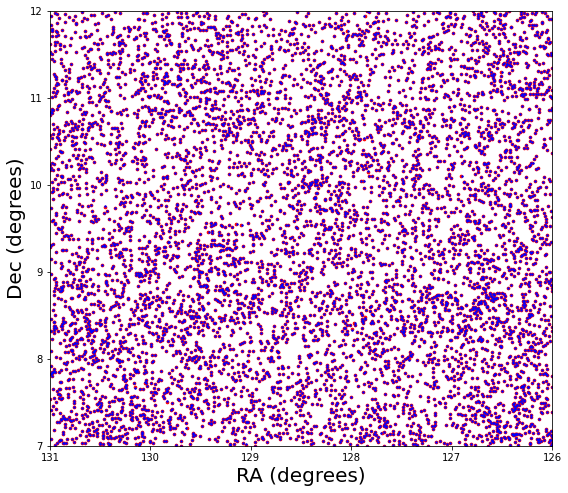

In [8]:
# convert RA coordinates from [0,360] to [-180,180] 
chgsign = np.where(result['ra'] > 180)
result['ra'][chgsign] = result['ra'][chgsign]-360.
result['plug_ra'][chgsign] = result['plug_ra'][chgsign]-360.

plt.figure(figsize=(9,8))

# plot RA, Dec from LS catalog in red with larger symbols
plt.scatter(result['ra'],result['dec'],s=7,color='r',marker='o')

# overplot RA, Dec from SDSS catalog in blue with smaller symbols
plt.scatter(result['plug_ra'],result['plug_dec'],s=2,color='b')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

plt.axis([xmin, xmax, ymin, ymax])
plt.xlim(reversed(plt.xlim())) # flip the x-axis
plt.xlabel("RA (degrees)", fontsize=20)
plt.ylabel("Dec (degrees)", fontsize=20)
plt.show()

## Visual Inspection of Large-Scale Structures

Plot the positions of a broad range of redshift, and overplot a thin slice in redshift to show possible structures within that slice.

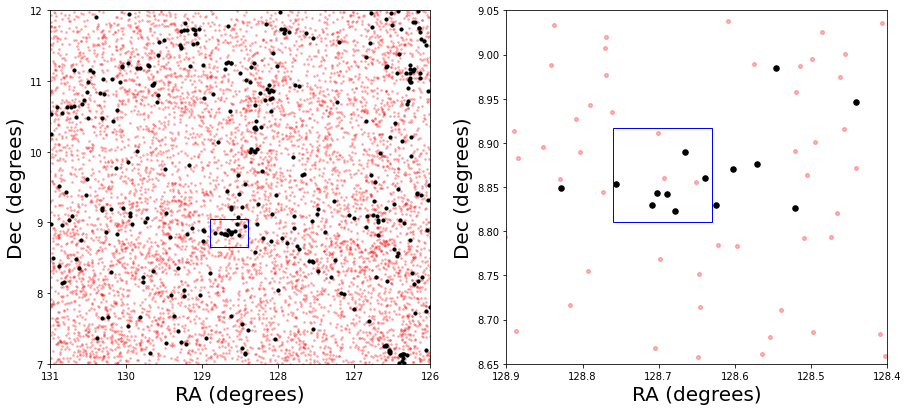

In [9]:
# Select redshift slice
rz = np.where((result['z'] >0.105) & (result['z']<0.125))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5))

# plot all points in red (all redshifts)
ax1.scatter(result['plug_ra'],result['plug_dec'],s=3,color='r',marker='o',alpha=0.25)

# overplot in blue objects in narrow redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=10,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)

# add rectangle to show where we zoom in next panel
ax1.add_patch(patches.Rectangle((128.65-0.25, 8.85-0.2),0.5,0.4,fill=False,color='b'))


## ZOOM IN A SMALLER REGION

# plot all points in red (all redshifts)
ax2.scatter(result['plug_ra'],result['plug_dec'],s=15,color='r',marker='o',alpha=0.3)

# overplot in blue objects in narrow redshift slice
ax2.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=30,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 128.4
xmax = 128.9
ymin = 8.65
ymax = 9.05

ax2.axis([xmin, xmax, ymin, ymax])
ax2.set_xlim(reversed(ax2.set_xlim())) # flip the x-axis
ax2.set_xlabel("RA (degrees)", fontsize=20)
ax2.set_ylabel("Dec (degrees)", fontsize=20)

# add rectangle to show where we zoom in next panel
ax2.add_patch(patches.Rectangle((128.63, 8.81),0.13,0.107,fill=False,color='b'))

plt.show()

Above, the left-hand panel shows a thin redshift slice (0.105 < *z* < 0.125, black symbols) among objects with redshifts from the spectroscopic SDSS DR13 sample (red symbols). We can see by eye some large-scale filamentary structures and overdensities. The blue rectangle shows a selected region where we zoom in the right-hand panel. On the latter, we further select a smaller region, which we will use in the next cell below.

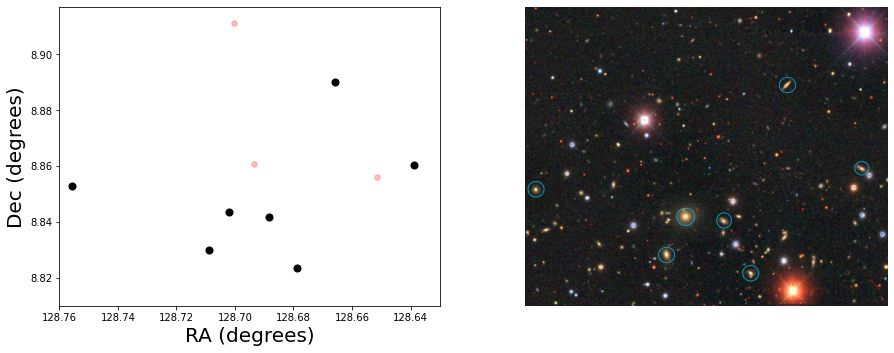

In [10]:
## ZOOM IN AGAIN OVER AN EVEN SMALLER REGION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5))

# plot all points in red (all redshifts)
ax1.scatter(result['plug_ra'],result['plug_dec'],s=30,color='r',marker='o',alpha=0.25)

# overplot in blue objects in narrow redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=50,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 128.63
xmax = 128.76
ymin = 8.81
ymax = 8.917

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)

## SHOW DECaLS IMAGE (screenshot pre-made but could instead implement image cutout)
im = plt.imread('DECaLS_screenshot_zoomIn_labels.jpg')
ax2.imshow(im)
ax2.axis('off')

plt.show()

The left-hand panel shows the small region enclosed in the blue rectangle that we chose above (right-hand panel). The galaxies in black are in the same narrow redshift slice as defined previously (0.105 < *z* < 0.125). The right-hand panel is an image cutout of the same region of the sky from the [LS sky viewer](http://legacysurvey.org/viewer?ra=128.7040&dec=8.8439&zoom=13&layer=decals-dr5). The galaxies encircled correspond to the points in black, and some or perhaps most of them likely belong to a galaxy cluster.

## Large-Scale Structures with LS Morphologies

There are many possible extensions to this work. For instance, one could plot again with symbols coded with object *type* (from LS) and/or *class* (from SDSS) and/or velocity dispersion (from SDSS) and/or other quantities. Here, we will start with the object "TYPE" from LS, related to the morphological shapes. 

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for LS DR3:
<ul>
<li>PSF (point spread function: size will vary with the seeing of the observations)</li>
<li>SIMP (“simple” galaxies: round, exponential profile with 0.45″ effective radius)</li>
<li>EXP (exponential profile; spiral galaxies)</li>
<li>DEV (deVaucouleurs profile; elliptical galaxies)</li>
<li>COMP (composite deVaucouleurs+exponential at same centroid)</li>
</ul>

Please note that starting in DR4 and in subsequent data releases, the SIMP model as been replaced with a REX model (Round Exponential).

<figure>
<img src="Gals_Qso.jpg", align="left", width=600>
<figcaption>**Figure:** Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

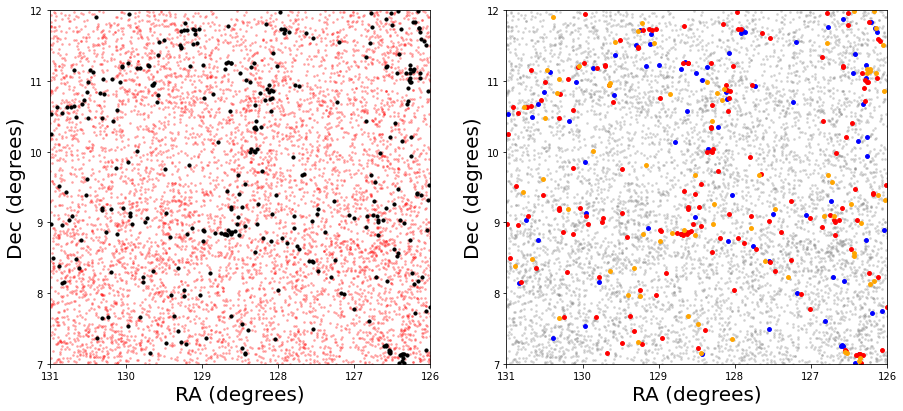

In [11]:
# Select redshift slice
rz = np.where((result['z'] >0.105) & (result['z']<0.125))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5))

# plot all points in red (all redshifts)
ax1.scatter(result['plug_ra'],result['plug_dec'],s=3,color='r',marker='o',alpha=0.25)

# overplot in blue objects in narrow redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=10,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)


# Select redshift slice and per type
rdev  = np.where((result['type']=='DEV') & (result['z'] >0.105) & (result['z']<0.125))
rexp  = np.where((result['type']=='EXP') & (result['z'] >0.105) & (result['z']<0.125))
rcomp = np.where((result['type']=='COMP') & (result['z'] >0.105) & (result['z']<0.125))

# plot all points in red (all redshifts)
ax2.scatter(result['plug_ra'],result['plug_dec'],s=3,color='gray',marker='o',alpha=0.25)

# overplot in blue objects in narrow redshift slice
ax2.scatter(result['plug_ra'][rexp],result['plug_dec'][rexp],s=15,color='b')         # blue = EXP
ax2.scatter(result['plug_ra'][rdev],result['plug_dec'][rdev],s=15,color='r')         # red  = DEV
ax2.scatter(result['plug_ra'][rcomp],result['plug_dec'][rcomp],s=15,color='orange')  # orange = COMP

plt.axis([xmin, xmax, ymin, ymax])
plt.xlim(reversed(plt.xlim())) # flip the x-axis
plt.xlabel("RA (degrees)", fontsize=20)
plt.ylabel("Dec (degrees)", fontsize=20)
plt.show()

<a class="anchor" id="exercise"></a>
## EXERCISE: Large-Scale Structures with Galaxy Colors

There are pre-computed colors available. The columns are described here:
http://datalab.noirlab.edu/query.php?name=ls_dr3.dr3_specobj_dr13

Another possibility would be to plot again the galaxies spatial coordinates, but color-coded according to their photometric colors. This is left as an exercise for the user, but feel free to get in touch with the Data Lab Team if you have questions.